# GCM Filters Kernel Benchmarking

## Baseline: `scipy.ndimage.uniform_filter`

This is considered a "good" implementation.

In [1]:
from scipy.ndimage import uniform_filter
import numpy as np
import pandas as pd

%load_ext ptime

In [2]:
shape = (1024, 1024)
data = np.random.rand(*shape)
data_u = np.random.rand(*shape)
data_v = np.random.rand(*shape)

In [3]:
uf_call = %timeit -o -n10 uniform_filter(data)

11.9 ms ± 545 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
output = np.zeros_like(data)
uf_call_w_output = %timeit -o -n10 uniform_filter(data, output=output)

10.7 ms ± 126 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
uf_ptime = %ptime -o -n6 uniform_filter(data)

Total serial time:   0.08 s
Total parallel time: 0.02 s
For a 4.05X speedup across 6 threads


In [6]:
uf_ptime_w_output = %ptime -o -n6 uniform_filter(data, output=output)

Total serial time:   0.07 s
Total parallel time: 0.01 s
For a 5.92X speedup across 6 threads


## Time GCM-Filters Functions in the same way
- How fast are our filters in single-threaded mode compared to the baseline?
- How do the scale in comparison?

In [7]:
import gcm_filters

In [8]:
regular_laplacian = gcm_filters.kernels.RegularLaplacian()

%timeit -n10 regular_laplacian(data)

12.1 ms ± 595 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%ptime -n6 regular_laplacian(data)

Total serial time:   0.08 s
Total parallel time: 0.05 s
For a 1.68X speedup across 6 threads


In [10]:
# convenience function to get a filter function

def get_filter_function(grid_type, grid_vars):

    filter = gcm_filters.Filter(
        filter_scale=4,
        dx_min=1,
        filter_shape=gcm_filters.FilterShape.TAPER,
        grid_type=grid_type,
        grid_vars=grid_vars,
    )
    
    return gcm_filters.filter._create_filter_func(
        filter.filter_spec,
        gcm_filters.kernels.ALL_KERNELS[grid_type]
    ), filter.filter_spec.n_steps_total

filter_function, nsteps_total = get_filter_function(gcm_filters.kernels.GridType.REGULAR, {})

In [11]:
%timeit -n5 filter_function(data)

243 ms ± 3.34 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [12]:
%ptime -n6 filter_function(data)

Total serial time:   1.29 s
Total parallel time: 1.04 s
For a 1.23X speedup across 6 threads


In [13]:
216 / nsteps_total

15.428571428571429

We just saw that the speed of the filter function is very nearly equal to the speed of the kernel (14 ms) times the number of steps in the filter.
The scaling is also similar. So from here on we will just focus on the kernels themselves, assuming whatever improvements we make to the filters will carry over to the kernels.

## Test All Kernels

In [14]:
results = {}

import warnings
warnings.simplefilter("ignore")

for name, kernel in gcm_filters.kernels.ALL_KERNELS.items():
    print(name)
    results[name.name] = {}
    extra_inputs = {arg: np.zeros_like(data) for arg in kernel.required_grid_args()}
    print(f' {len(extra_inputs)} extra args')
    results[name.name]['init'] = %timeit -o -n10 kernel_func = kernel(**extra_inputs)
    kernel_func = kernel(**extra_inputs)
    if 'VECTOR' in name.name:
        results[name.name]['call'] = %timeit -o -n10 kernel_func(data_u, data_v)
        results[name.name]['call_ptime'] = %ptime -o -n6 kernel_func(data_u, data_v)
    else:
        results[name.name]['call'] = %timeit -o -n10 kernel_func(data)
        results[name.name]['call_ptime'] = %ptime -o -n6 kernel_func(data)

    

GridType.REGULAR
 0 extra args
247 ns ± 76.2 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
13.9 ms ± 281 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Total serial time:   0.10 s
Total parallel time: 0.06 s
For a 1.58X speedup across 6 threads
GridType.REGULAR_WITH_LAND
 1 extra args
10.8 ms ± 71.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
24.1 ms ± 366 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Total serial time:   0.15 s
Total parallel time: 0.11 s
For a 1.33X speedup across 6 threads
GridType.IRREGULAR_WITH_LAND
 8 extra args
5.5 ms ± 511 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
28.2 ms ± 2.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Total serial time:   0.19 s
Total parallel time: 0.14 s
For a 1.40X speedup across 6 threads
GridType.TRIPOLAR_REGULAR_WITH_LAND
 1 extra args
6.69 ms ± 437 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
19.7 ms ± 132 µs per loop (mean ± std. dev. of 7 runs, 10 loops e

In [15]:
results_for_pandas = {
    name: {
        'init_avg': res['init'].average,
        'init_std': res['init'].stdev,
        'call_avg': res['call'].average,
        'call_std': res['call'].stdev,
        'parallel_speedup': res['call_ptime'].speedup
    }
    for name, res in results.items()
}

results_for_pandas['ndimage.uniform_filter'] = {
    'call_avg': uf_call.average,
    'call_std': uf_call.stdev,
    'parallel_speedup': uf_ptime.speedup
}

results_for_pandas['ndimage.uniform_filter (output)'] = {
    'call_avg': uf_call_w_output.average,
    'call_std': uf_call_w_output.stdev,
    'parallel_speedup': uf_ptime_w_output.speedup
}

df = pd.DataFrame(results_for_pandas).transpose()
df

,init_avg,init_std,call_avg,call_std,parallel_speedup
REGULAR,2.468571e-07,7.623177e-08,0.013928,0.000281,1.580123
REGULAR_WITH_LAND,1.076826e-02,7.134474e-05,0.024120,0.000366,1.329384
IRREGULAR_WITH_LAND,5.503437e-03,5.108730e-04,0.028195,0.002679,1.397791
TRIPOLAR_REGULAR_WITH_LAND,6.685203e-03,4.371660e-04,0.019675,0.000132,1.158377
TRIPOLAR_POP_WITH_LAND,1.363606e-02,9.677481e-05,0.029463,0.000419,1.428361
VECTOR_C_GRID,2.537815e-02,2.190825e-03,0.084961,0.007639,1.380396
ndimage.uniform_filter,NaN,NaN,0.011904,0.000545,4.046563
ndimage.uniform_filter (output),NaN,NaN,0.010684,0.000126,5.920890


<AxesSubplot:>

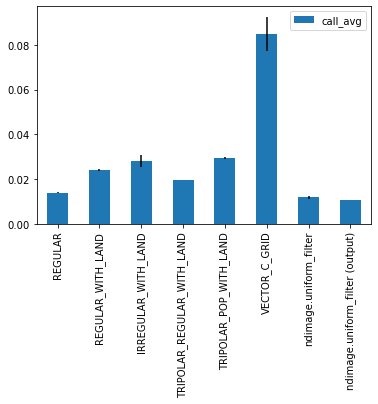

In [16]:
df.plot(kind='bar', y='call_avg', yerr='call_std')

<AxesSubplot:>

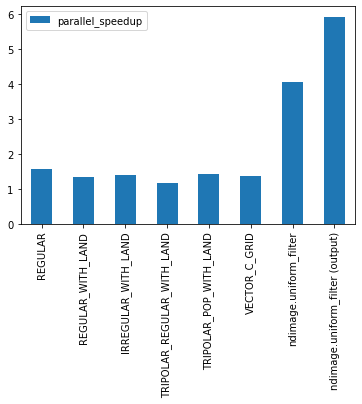

In [17]:
df.plot(kind='bar', y='parallel_speedup')